# Import Data and Preprocessing

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"applejin","key":"0b93924b947f72a219bb11234c07cc77"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces

100% 3.75G/3.75G [01:37<00:00, 40.8MB/s]
100% 3.75G/3.75G [01:37<00:00, 41.2MB/s]


In [ ]:
!unzip 140k-real-and-fake-faces.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: real_vs_fake/real-vs-fake/valid/real/34832.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34836.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34839.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34847.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34848.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34852.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34861.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34864.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34868.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34877.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34883.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34887.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34891.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34894.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34904.jpg  
  inflating: real_vs_fake/real-vs-fake/vali

In [ ]:
import os
import glob
import pandas as pd

main_path = './real_vs_fake/real-vs-fake'

train_dir = os.path.join(main_path, 'train')
valid_dir = os.path.join(main_path, 'valid')
test_dir = os.path.join(main_path, 'test')

images_df = {
    "folder":[],
    "image_path":[],
    "label":[]
}

for folder in os.listdir(main_path): #iterate on each train, valid and test folder
    for label in os.listdir(main_path + "/" + folder): #iterate on fake and real folders (labels)
        for img in glob.glob(main_path + "/" + folder + "/" + label + "/*.jpg"):
            images_df["folder"].append(folder)
            images_df["image_path"].append(img)
            images_df["label"].append(label)
images_df = pd.DataFrame(images_df)
images_df

folder                                         image_path label
0        test  ./real_vs_fake/real-vs-fake/test/fake/AYTOBQQP...  fake
1        test  ./real_vs_fake/real-vs-fake/test/fake/4QJDSXE3...  fake
2        test  ./real_vs_fake/real-vs-fake/test/fake/PXFWOQGJ...  fake
3        test  ./real_vs_fake/real-vs-fake/test/fake/9KG6KVIH...  fake
4        test  ./real_vs_fake/real-vs-fake/test/fake/SLMMPVPE...  fake
...       ...                                                ...   ...
139995  train   ./real_vs_fake/real-vs-fake/train/real/49858.jpg  real
139996  train   ./real_vs_fake/real-vs-fake/train/real/50845.jpg  real
139997  train   ./real_vs_fake/real-vs-fake/train/real/14158.jpg  real
139998  train   ./real_vs_fake/real-vs-fake/train/real/68890.jpg  real
139999  train   ./real_vs_fake/real-vs-fake/train/real/59423.jpg  real

[140000 rows x 3 columns]

In [ ]:
## ela preprosessing
from PIL import Image, ImageChops, ImageEnhance

train_dir = os.path.join(main_path, 'train_ela')
valid_dir = os.path.join(main_path, 'valid_ela')
test_dir = os.path.join(main_path, 'test_ela')

def convert_to_ela_image(path, quality):
    filename = path
    resaved_filename = filename.split('.')[0] + '.resaved.jpg'
    ELA_filename = filename.split('.')[0] + '.ela.png'

    im = Image.open(filename).convert('RGB')
    # im.save(resaved_filename, 'JPEG', quality=quality)
    resaved_im = Image.open(resaved_filename)

    ela_im = ImageChops.difference(im, resaved_im)

    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)

    return ela_im

In [ ]:
real_grouped_df = images_df[images_df['label'] == "real"].groupby('folder')
fake_grouped_df = images_df[images_df['label'] == "fake"].groupby('folder')

import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
import seaborn as sns
from sklearn import metrics

image_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                                  rescale=1./255.,
                                  horizontal_flip=True,
                                  )

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

In [ ]:
train_ds = image_train_gen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
)

valid_ds = image_gen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary'
)

test_ds = image_gen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
    shuffle=False) #shuffle disabled

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [ ]:
input_shape = (256, 256, 3)

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

base_model.trainable = False

for layer in base_model.layers[-10:]: # unfreeze the last 10 layers
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

# from tensorflow.keras.layers import Dropout
# x = Dropout(0.5)(x)  # add a dropout layer
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001), # lower the learning rate
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
files.upload()

Saving model_best_weights.h5 to model_best_weights.h5


In [ ]:
model.load_weights(filepath='model_best_weights.h5')
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

313/313 [==============================] - 63s 199ms/step - loss: 0.1416 - accuracy: 0.9413
Test Loss: 0.14161750674247742, Test Accuracy: 0.941349983215332


# gradCAM

The reference code we used to develop gradCAM can be found [here](https://www.kaggle.com/code/nicoladisabato/fake-face-detection-with-keras-accuracy-0-987).

In [ ]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import keras

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.5):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


In [ ]:
# Get the names of all layers in the model.
for idx in range(len(model.layers)):
  print(model.get_layer(index = idx).name)

input_1
conv1
conv1_bn
conv1_relu
conv_dw_1
conv_dw_1_bn
conv_dw_1_relu
conv_pw_1
conv_pw_1_bn
conv_pw_1_relu
conv_pad_2
conv_dw_2
conv_dw_2_bn
conv_dw_2_relu
conv_pw_2
conv_pw_2_bn
conv_pw_2_relu
conv_dw_3
conv_dw_3_bn
conv_dw_3_relu
conv_pw_3
conv_pw_3_bn
conv_pw_3_relu
conv_pad_4
conv_dw_4
conv_dw_4_bn
conv_dw_4_relu
conv_pw_4
conv_pw_4_bn
conv_pw_4_relu
conv_dw_5
conv_dw_5_bn
conv_dw_5_relu
conv_pw_5
conv_pw_5_bn
conv_pw_5_relu
conv_pad_6
conv_dw_6
conv_dw_6_bn
conv_dw_6_relu
conv_pw_6
conv_pw_6_bn
conv_pw_6_relu
conv_dw_7
conv_dw_7_bn
conv_dw_7_relu
conv_pw_7
conv_pw_7_bn
conv_pw_7_relu
conv_dw_8
conv_dw_8_bn
conv_dw_8_relu
conv_pw_8
conv_pw_8_bn
conv_pw_8_relu
conv_dw_9
conv_dw_9_bn
conv_dw_9_relu
conv_pw_9
conv_pw_9_bn
conv_pw_9_relu
conv_dw_10
conv_dw_10_bn
conv_dw_10_relu
conv_pw_10
conv_pw_10_bn
conv_pw_10_relu
conv_dw_11
conv_dw_11_bn
conv_dw_11_relu
conv_pw_11
conv_pw_11_bn
conv_pw_11_relu
conv_pad_12
conv_dw_12
conv_dw_12_bn
conv_dw_12_relu
conv_pw_12
conv_pw_12_bn
conv_pw

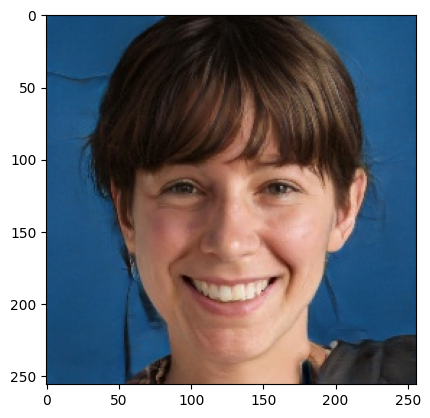

In [ ]:
import numpy as np

img_size = (256, 256)


last_conv_layer_name = "dense_1"

img_path = "/content/real_vs_fake/real-vs-fake/test/fake/02NUKFGPSJ.jpg"

test_image = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256, 3))
plt.imshow(test_image)

img = tf.keras.preprocessing.image.img_to_array(test_image)
img = np.expand_dims(img, axis=0)
img = img/255.

1/1 [==============================] - 0s 21ms/step
Predicted: [[-5.370525]]


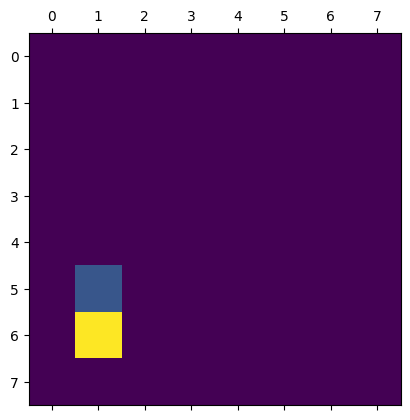

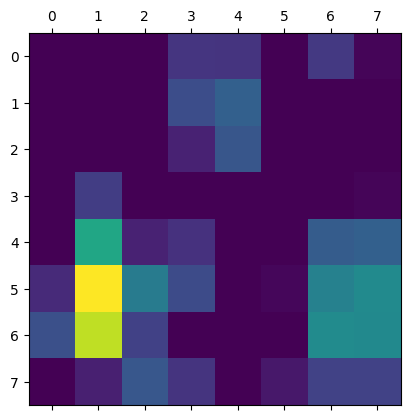

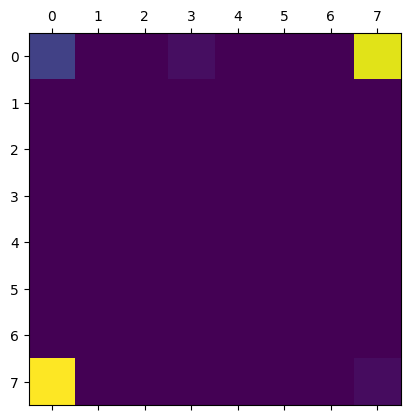

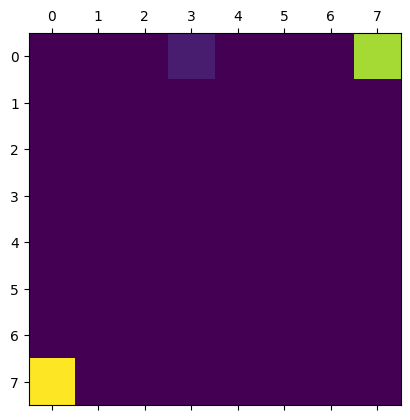

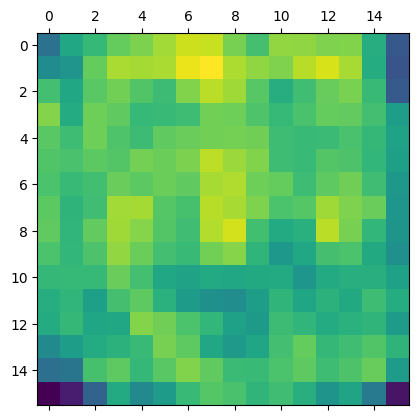

In [ ]:
# Remove last layer's softmax
# model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img)
print("Predicted:", preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img, model, "conv_pw_13")
heatmap_2 = make_gradcam_heatmap(img, model, "conv_dw_13")
heatmap_3 = make_gradcam_heatmap(img, model, "conv_pw_12")
heatmap_4 = make_gradcam_heatmap(img, model, "conv_dw_12")
heatmap_5 = make_gradcam_heatmap(img, model, "conv_pw_11")

# Display heatmap
plt.matshow(heatmap)
plt.matshow(heatmap_2)
plt.matshow(heatmap_3)
plt.matshow(heatmap_4)
plt.matshow(heatmap_5)
plt.show()

<ipython-input-15-10cb15bf560a>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


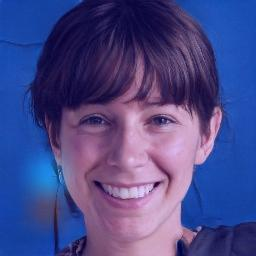

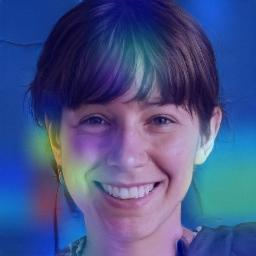

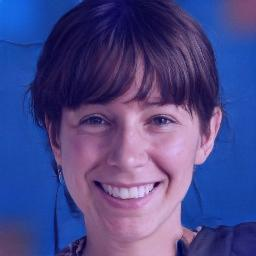

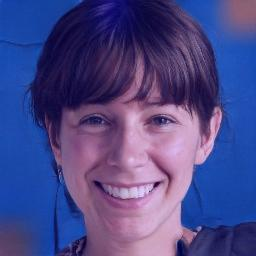

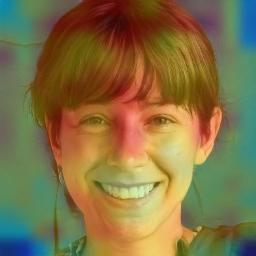

In [ ]:
save_and_display_gradcam(img_path, heatmap)
save_and_display_gradcam(img_path, heatmap_2)
save_and_display_gradcam(img_path, heatmap_3)
save_and_display_gradcam(img_path, heatmap_4)
save_and_display_gradcam(img_path, heatmap_5)

# gradCAM (Average)

The reference code we used to develop gradCAM can be found [here](https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353).

In [ ]:
import cv2
def get_processed_img(img_path):
  test_image = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256, 3))
  img = tf.keras.preprocessing.image.img_to_array(test_image)
  img = np.expand_dims(img, axis=0)
  img = img/255.
  return img

def get_fused_heatmap(img_path, model):

  test_image = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256, 3))
  img = tf.keras.preprocessing.image.img_to_array(test_image)
  img = np.expand_dims(img, axis=0)
  img = img/255.

  layer_names = []
  for idx in range(len(model.layers)):
    name = model.get_layer(index = idx).name
    if "input" not in name and "bn" not in name and "relu" not in name and "dense" not in name and "pad" not in name and "pool" not in name and "conv1" not in name:
      layer_names.append(name)

  heatmaps = []
  for layer_name in layer_names:
    this_heatmap = make_gradcam_heatmap(img, model, layer_name)
    # print(this_heatmap.shape)
    this_heatmap = cv2.resize(this_heatmap, (img.shape[1], img.shape[2]))
    # print(this_heatmap.shape)
    heatmaps.append(this_heatmap)

  fused_heatmap = np.mean(heatmaps, axis = 0)

  return fused_heatmap

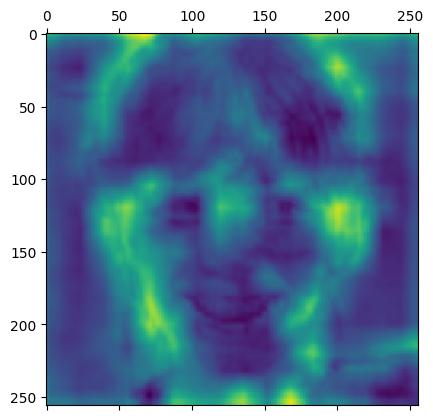

In [ ]:
img_path = "/content/real_vs_fake/real-vs-fake/test/fake/02NUKFGPSJ.jpg"
fused_heatmap1 = get_fused_heatmap(img_path, model)
plt.matshow(fused_heatmap1)

1/1 [==============================] - 1s 606ms/step


Text(0.5, 1.0, 'This image is 99.54% Fake and 0.46% Real.')

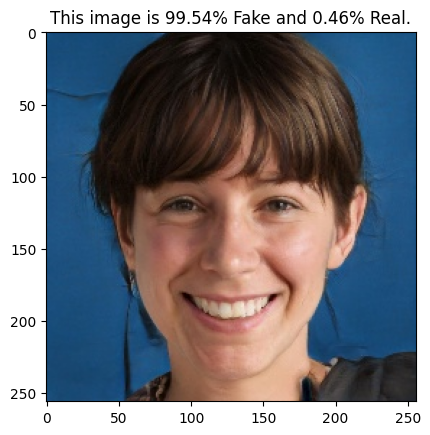

In [ ]:
test_image = tf.keras.preprocessing.image.load_img('/content/real_vs_fake/real-vs-fake/test/fake/02NUKFGPSJ.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)


test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.

result = model.predict(test_image_arr)
plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

<ipython-input-15-10cb15bf560a>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


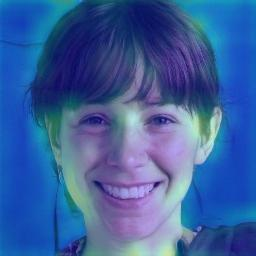

In [ ]:
save_and_display_gradcam(img_path, fused_heatmap1)

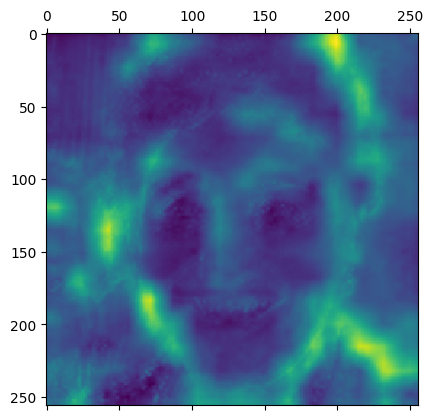

In [ ]:
img_path2 = "/content/real_vs_fake/real-vs-fake/test/fake/00QKZTHTLF.jpg"
fused_heatmap2 = get_fused_heatmap(img_path2, model)
plt.matshow(fused_heatmap2)

<ipython-input-15-10cb15bf560a>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


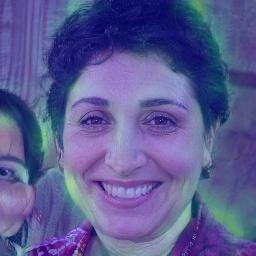

In [ ]:
save_and_display_gradcam(img_path2, fused_heatmap2)

# Apply gradCAM on different images (TN/TP/FN/FP)

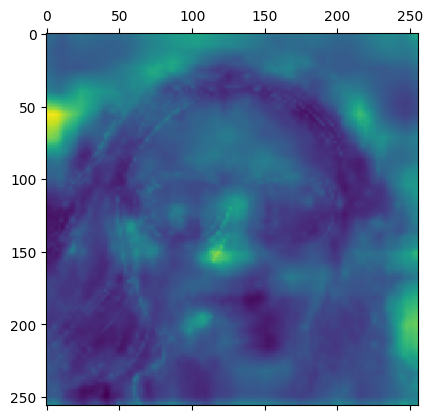

In [ ]:
# grad-cam for real images
img_path_real1 = "/content/real_vs_fake/real-vs-fake/test/real/00025.jpg"
fused_heatmap3 = get_fused_heatmap(img_path_real1, model)
plt.matshow(fused_heatmap3)

<ipython-input-15-10cb15bf560a>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


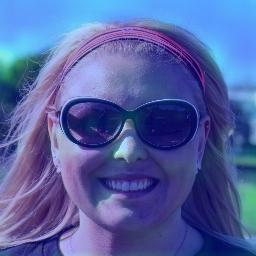

In [ ]:
save_and_display_gradcam(img_path_real1, fused_heatmap3)

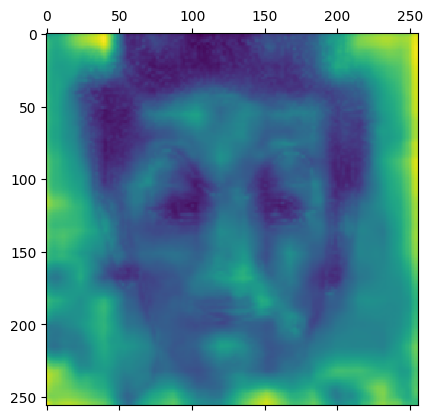

In [ ]:
img_path_real2 = "/content/real_vs_fake/real-vs-fake/test/real/00243.jpg"
fused_heatmap4= get_fused_heatmap(img_path_real2, model)
plt.matshow(fused_heatmap4)

<ipython-input-15-10cb15bf560a>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


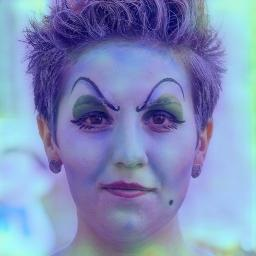

In [ ]:
save_and_display_gradcam(img_path_real2, fused_heatmap4)

<ipython-input-15-10cb15bf560a>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


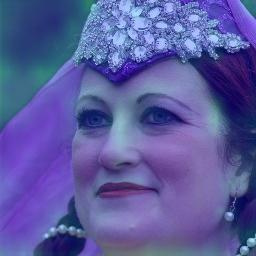

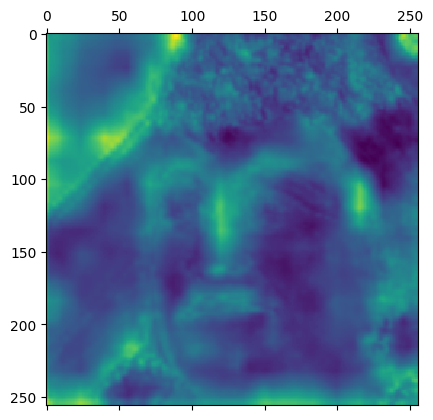

In [ ]:
img_path_real3 = "/content/real_vs_fake/real-vs-fake/test/real/00170.jpg"
fused_heatmap5 = get_fused_heatmap(img_path_real3, model)
plt.matshow(fused_heatmap5)
save_and_display_gradcam(img_path_real3, fused_heatmap5)

## check fp and fn ##

In [ ]:
prediction_result_ontest = model.predict(test_ds)

313/313 [==============================] - 78s 247ms/step


In [ ]:
prediction_result_ontest

array([[0.08076325],
       [0.00337348],
       [0.00177914],
       ...,
       [0.9808019 ],
       [0.97705835],
       [0.9022064 ]], dtype=float32)

In [ ]:
prediction_result_ontest_binary = np.where(prediction_result_ontest > 0.5, 1, 0)
prediction_result_ontest_binary

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [ ]:
images_df

folder                                         image_path label
0        test  ./real_vs_fake/real-vs-fake/test/fake/AYTOBQQP...  fake
1        test  ./real_vs_fake/real-vs-fake/test/fake/4QJDSXE3...  fake
2        test  ./real_vs_fake/real-vs-fake/test/fake/PXFWOQGJ...  fake
3        test  ./real_vs_fake/real-vs-fake/test/fake/9KG6KVIH...  fake
4        test  ./real_vs_fake/real-vs-fake/test/fake/SLMMPVPE...  fake
...       ...                                                ...   ...
139995  train   ./real_vs_fake/real-vs-fake/train/real/49858.jpg  real
139996  train   ./real_vs_fake/real-vs-fake/train/real/50845.jpg  real
139997  train   ./real_vs_fake/real-vs-fake/train/real/14158.jpg  real
139998  train   ./real_vs_fake/real-vs-fake/train/real/68890.jpg  real
139999  train   ./real_vs_fake/real-vs-fake/train/real/59423.jpg  real

[140000 rows x 3 columns]

In [ ]:
test_df = images_df[images_df["folder"] == "test"]

In [ ]:
test_df_shuffled = test_df.sample(frac=1).iloc[:500]
test_df_shuffled

folder                                         image_path label
13346   test    ./real_vs_fake/real-vs-fake/test/real/46593.jpg  real
2181    test  ./real_vs_fake/real-vs-fake/test/fake/E1D9A7WO...  fake
13150   test    ./real_vs_fake/real-vs-fake/test/real/35712.jpg  real
6298    test  ./real_vs_fake/real-vs-fake/test/fake/1NT8IVFQ...  fake
9577    test  ./real_vs_fake/real-vs-fake/test/fake/1YZJFFJA...  fake
...      ...                                                ...   ...
11618   test    ./real_vs_fake/real-vs-fake/test/real/40962.jpg  real
1213    test  ./real_vs_fake/real-vs-fake/test/fake/N4GLAFVC...  fake
6712    test  ./real_vs_fake/real-vs-fake/test/fake/FZFQ8V1Z...  fake
18584   test    ./real_vs_fake/real-vs-fake/test/real/06312.jpg  real
14597   test    ./real_vs_fake/real-vs-fake/test/real/59728.jpg  real

[500 rows x 3 columns]

In [ ]:
pred_results = []

for i in range(len(test_df_shuffled)):

  img_path = test_df_shuffled.iloc[i]["image_path"]
  img = get_processed_img(img_path)
  pred_results.append(model.predict(img))

pred_results = np.array(pred_results)
pred_results_binary = np.where(pred_results > 0.5, 1, 0)
pred_results_binary

1/1 [==============================] - 0s 22ms/step


array([[[1]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[1]],

       [[0]],

       [[0]],

       [[1]],

       [[0]],

       [[0]],

       [[1]],

       [[0]],

       [[1]],

       [[1]],

       [[1]],

       [[1]],

       [[0]],

       [[0]],

       [[0]],

       [[1]],

       [[0]],

       [[0]],

       [[0]],

       [[1]],

       [[0]],

       [[0]],

       [[1]],

       [[0]],

       [[0]],

       [[1]],

       [[1]],

       [[0]],

       [[1]],

       [[1]],

       [[1]],

       [[0]],

       [[1]],

       [[1]],

       [[0]],

       [[1]],

       [[0]],

       [[0]],

       [[1]],

       [[1]],

       [[0]],

       [[1]],

       [[0]],

       [[0]],

       [[1]],

       [[1]],

       [[0]],

       [[0]],

       [[1]],

       [[1]],

       [[1]],

       [[0]],

       [[1]],

       [[1]],

       [[1]],

       [[1]],

       [[0]],

       [[0]],

       [[0]],

       [[1]],

       [[0]],

       [[1

In [ ]:
pred_results_binary = pred_results_binary.reshape(-1, 1)

In [ ]:
test_df_shuffled

folder                                         image_path label
13346   test    ./real_vs_fake/real-vs-fake/test/real/46593.jpg  real
2181    test  ./real_vs_fake/real-vs-fake/test/fake/E1D9A7WO...  fake
13150   test    ./real_vs_fake/real-vs-fake/test/real/35712.jpg  real
6298    test  ./real_vs_fake/real-vs-fake/test/fake/1NT8IVFQ...  fake
9577    test  ./real_vs_fake/real-vs-fake/test/fake/1YZJFFJA...  fake
...      ...                                                ...   ...
11618   test    ./real_vs_fake/real-vs-fake/test/real/40962.jpg  real
1213    test  ./real_vs_fake/real-vs-fake/test/fake/N4GLAFVC...  fake
6712    test  ./real_vs_fake/real-vs-fake/test/fake/FZFQ8V1Z...  fake
18584   test    ./real_vs_fake/real-vs-fake/test/real/06312.jpg  real
14597   test    ./real_vs_fake/real-vs-fake/test/real/59728.jpg  real

[500 rows x 3 columns]

In [ ]:

test_df_shuffled["pred_result"] = pred_results_binary

test_df_shuffled["pred_result"][test_df_shuffled["pred_result"] == 0] = "fake"
test_df_shuffled["pred_result"][test_df_shuffled["pred_result"] == 1] = "real"
test_df_shuffled

<ipython-input-176-82b7ac8412b6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_shuffled["pred_result"][test_df_shuffled["pred_result"] == 0] = "fake"


folder                                         image_path label  \
13346   test    ./real_vs_fake/real-vs-fake/test/real/46593.jpg  real   
2181    test  ./real_vs_fake/real-vs-fake/test/fake/E1D9A7WO...  fake   
13150   test    ./real_vs_fake/real-vs-fake/test/real/35712.jpg  real   
6298    test  ./real_vs_fake/real-vs-fake/test/fake/1NT8IVFQ...  fake   
9577    test  ./real_vs_fake/real-vs-fake/test/fake/1YZJFFJA...  fake   
...      ...                                                ...   ...   
11618   test    ./real_vs_fake/real-vs-fake/test/real/40962.jpg  real   
1213    test  ./real_vs_fake/real-vs-fake/test/fake/N4GLAFVC...  fake   
6712    test  ./real_vs_fake/real-vs-fake/test/fake/FZFQ8V1Z...  fake   
18584   test    ./real_vs_fake/real-vs-fake/test/real/06312.jpg  real   
14597   test    ./real_vs_fake/real-vs-fake/test/real/59728.jpg  real   

      pred_result  
13346        real  
2181         fake  
13150        fake  
6298         fake  
9577         fake  
...           ...  
11618        real  
1213         fake  
6712         fake  
18584        real  
14597        real  

[500 rows x 4 columns]

In [ ]:
test_df_FN = test_df_shuffled[(test_df_shuffled["pred_result"] == "fake") & (test_df_shuffled["label"] == "real")]
test_df_FN

folder                                       image_path label  \
13150   test  ./real_vs_fake/real-vs-fake/test/real/35712.jpg  real   
16340   test  ./real_vs_fake/real-vs-fake/test/real/56680.jpg  real   
11788   test  ./real_vs_fake/real-vs-fake/test/real/33004.jpg  real   
15011   test  ./real_vs_fake/real-vs-fake/test/real/30987.jpg  real   
14361   test  ./real_vs_fake/real-vs-fake/test/real/61185.jpg  real   
10032   test  ./real_vs_fake/real-vs-fake/test/real/20975.jpg  real   
14305   test  ./real_vs_fake/real-vs-fake/test/real/63092.jpg  real   
10276   test  ./real_vs_fake/real-vs-fake/test/real/43407.jpg  real   
19050   test  ./real_vs_fake/real-vs-fake/test/real/52868.jpg  real   
13547   test  ./real_vs_fake/real-vs-fake/test/real/20598.jpg  real   
12565   test  ./real_vs_fake/real-vs-fake/test/real/68732.jpg  real   
18935   test  ./real_vs_fake/real-vs-fake/test/real/55827.jpg  real   
17769   test  ./real_vs_fake/real-vs-fake/test/real/53693.jpg  real   
17701   test  ./real_vs_fake/real-vs-fake/test/real/52890.jpg  real   
10842   test  ./real_vs_fake/real-vs-fake/test/real/43310.jpg  real   
19145   test  ./real_vs_fake/real-vs-fake/test/real/15388.jpg  real   
10463   test  ./real_vs_fake/real-vs-fake/test/real/61969.jpg  real   
19109   test  ./real_vs_fake/real-vs-fake/test/real/00189.jpg  real   
13350   test  ./real_vs_fake/real-vs-fake/test/real/14947.jpg  real   
11997   test  ./real_vs_fake/real-vs-fake/test/real/40410.jpg  real   
19428   test  ./real_vs_fake/real-vs-fake/test/real/33407.jpg  real   
13227   test  ./real_vs_fake/real-vs-fake/test/real/06644.jpg  real   
19853   test  ./real_vs_fake/real-vs-fake/test/real/61490.jpg  real   

      pred_result  
13150        fake  
16340        fake  
11788        fake  
15011        fake  
14361        fake  
10032        fake  
14305        fake  
10276        fake  
19050        fake  
13547        fake  
12565        fake  
18935        fake  
17769        fake  
17701        fake  
10842        fake  
19145        fake  
10463        fake  
19109        fake  
13350        fake  
11997        fake  
19428        fake  
13227        fake  
19853        fake

In [ ]:
test_df_FP = test_df_shuffled[(test_df_shuffled["pred_result"] == "real") & (test_df_shuffled["label"] == "fake")]
test_df_FP

folder                                         image_path label  \
1585   test  ./real_vs_fake/real-vs-fake/test/fake/R9TQDAC1...  fake   
4827   test  ./real_vs_fake/real-vs-fake/test/fake/LM4J0QR3...  fake   
3648   test  ./real_vs_fake/real-vs-fake/test/fake/LK8106X9...  fake   
5355   test  ./real_vs_fake/real-vs-fake/test/fake/OUTA3YYQ...  fake   
4072   test  ./real_vs_fake/real-vs-fake/test/fake/CYMWHHQU...  fake   

     pred_result  
1585        real  
4827        real  
3648        real  
5355        real  
4072        real

<ipython-input-15-10cb15bf560a>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


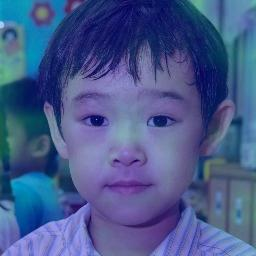

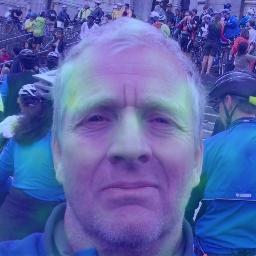

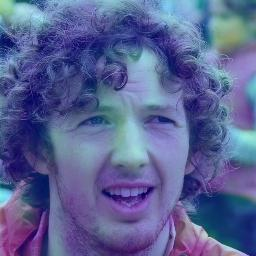

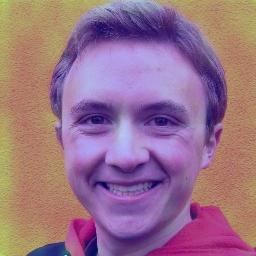

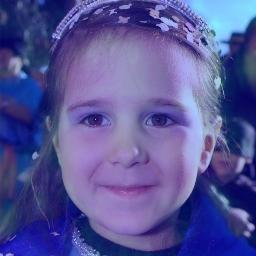

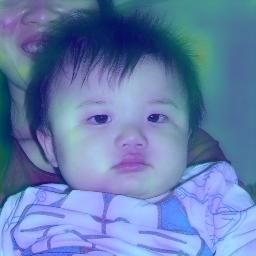

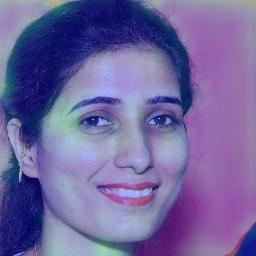

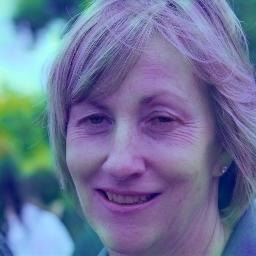

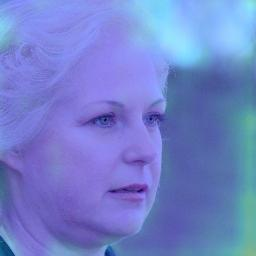

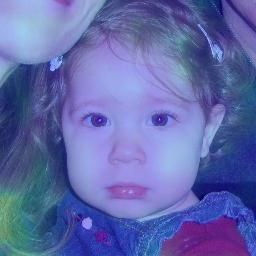

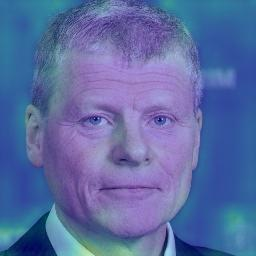

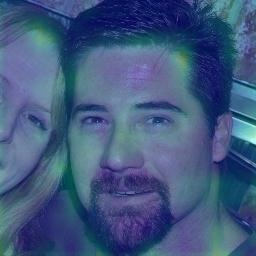

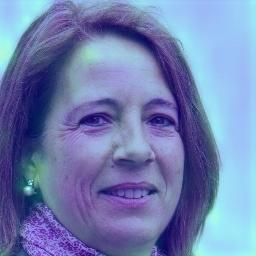

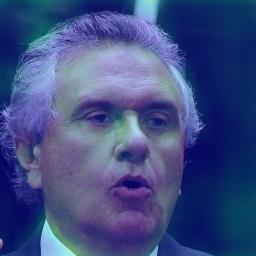

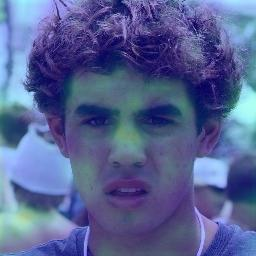

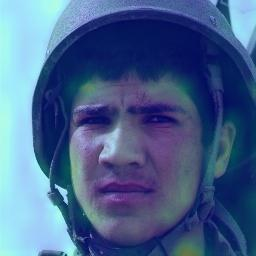

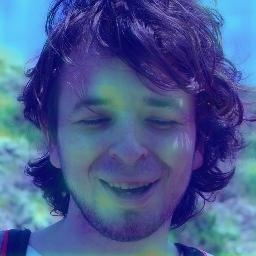

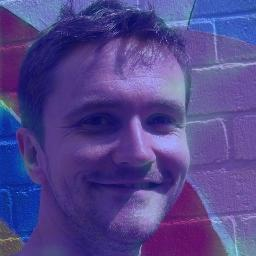

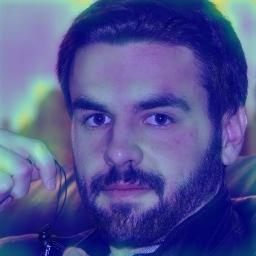

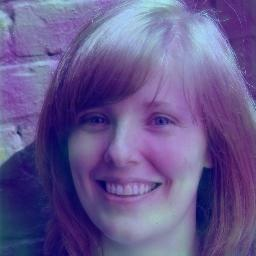

<ipython-input-179-252375195f72>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.matshow(fused_heatmap_fn1)


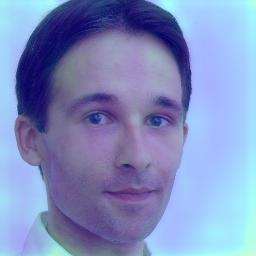

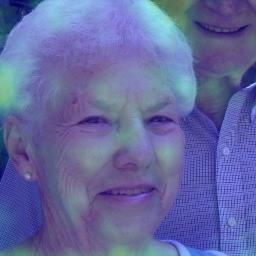

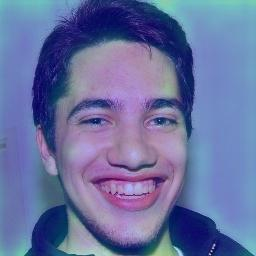

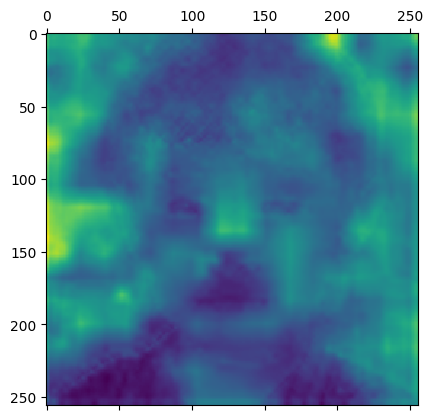

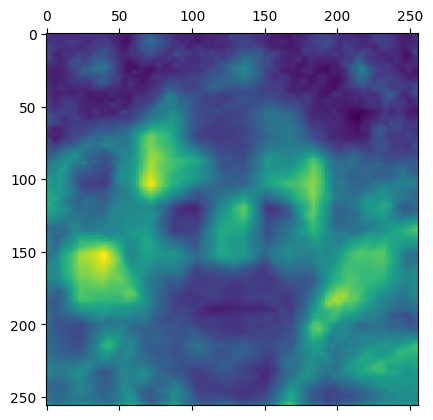

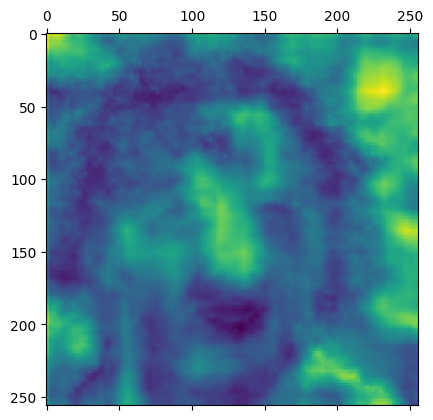

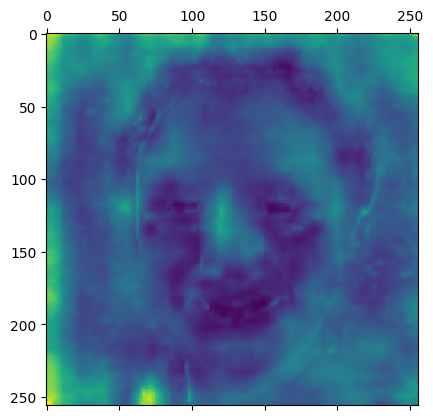

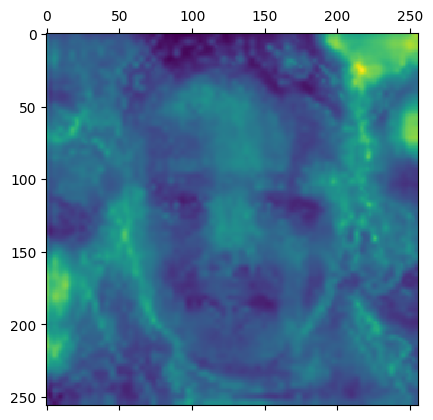

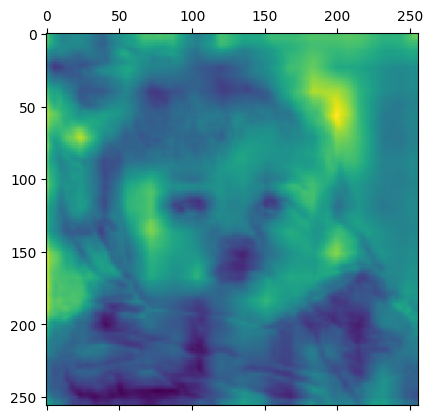

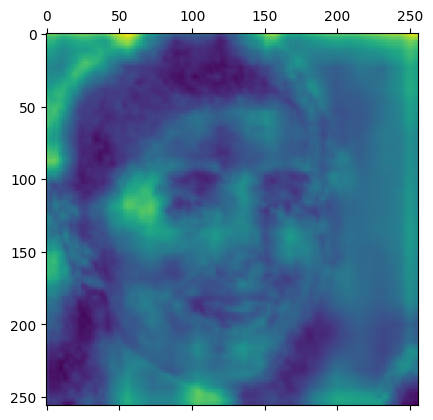

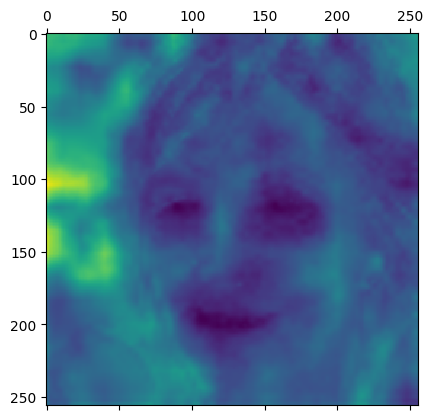

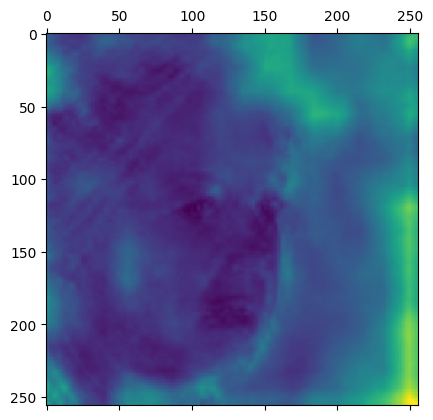

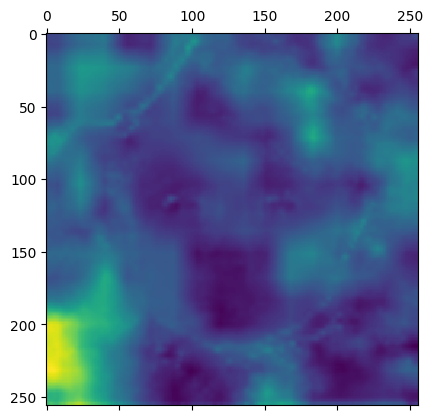

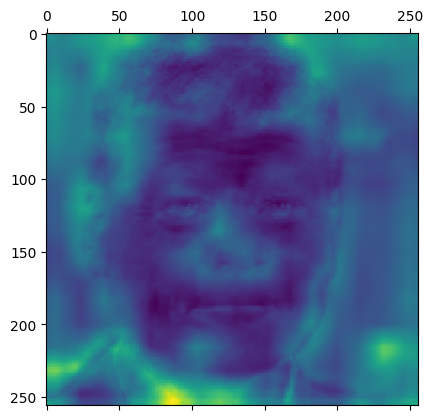

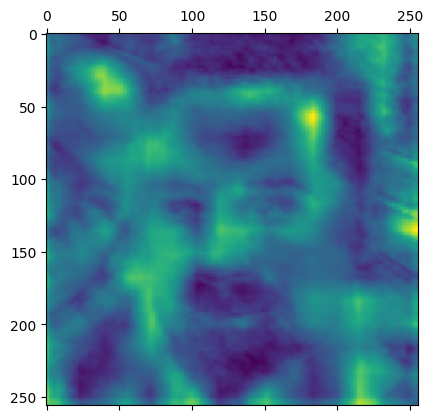

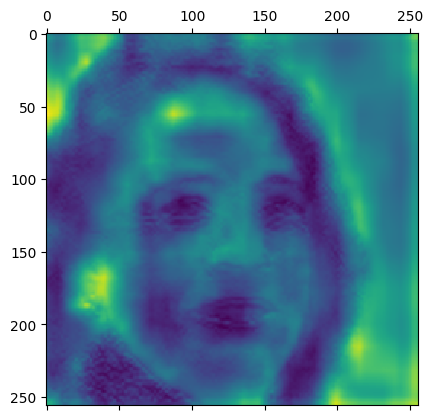

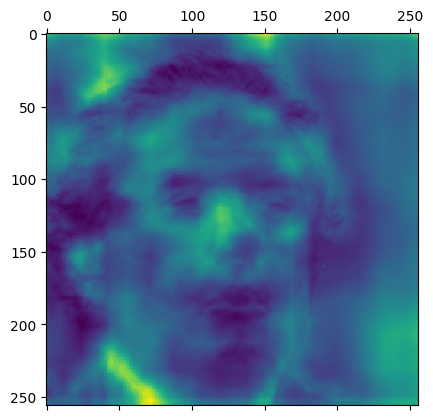

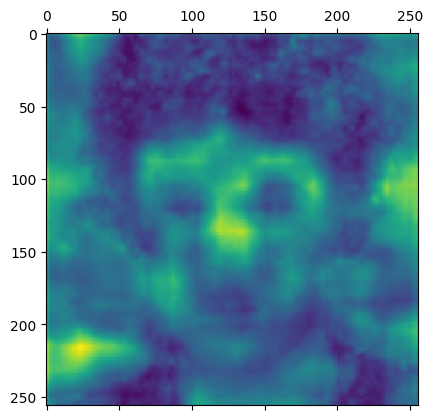

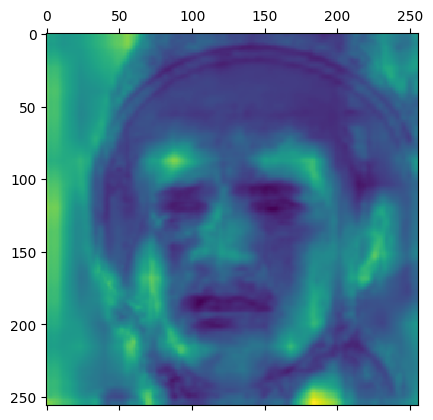

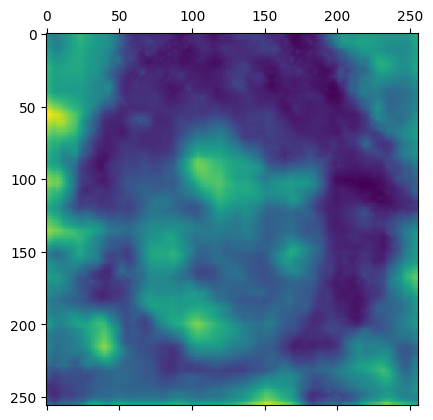

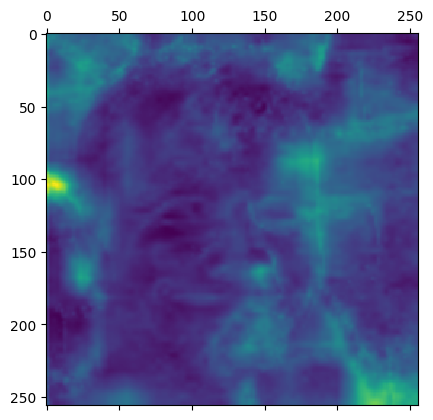

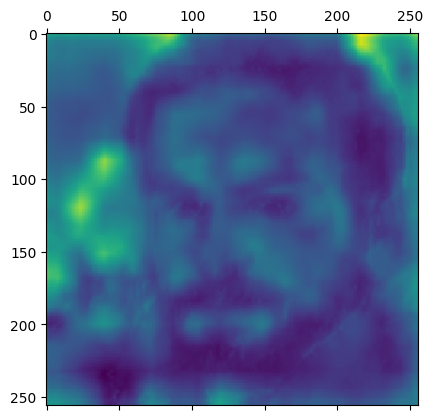

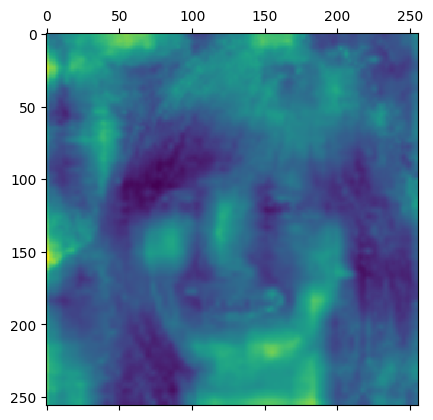

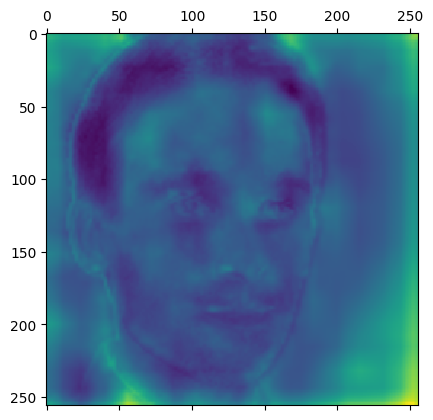

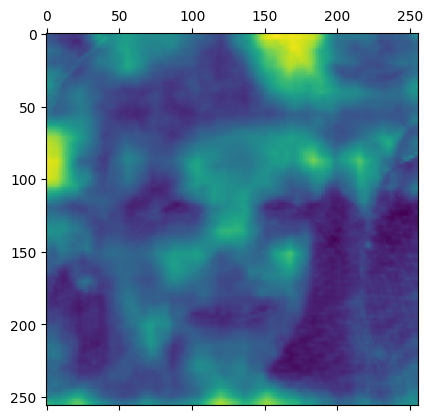

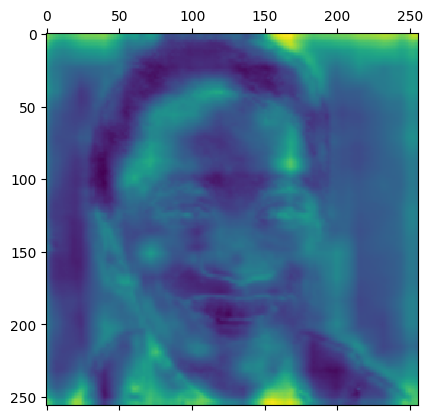

In [ ]:
## FN examples
for i in range(len(test_df_FN)):
  img_fn_path1 = test_df_FN.iloc[i]["image_path"]
  # img_fn_path2 = test_df_FN.iloc[1]["image_path"]
  fused_heatmap_fn1 = get_fused_heatmap(img_fn_path1, model)
  plt.matshow(fused_heatmap_fn1)
  save_and_display_gradcam(img_fn_path1, fused_heatmap_fn1)

<ipython-input-15-10cb15bf560a>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


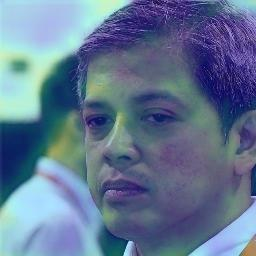

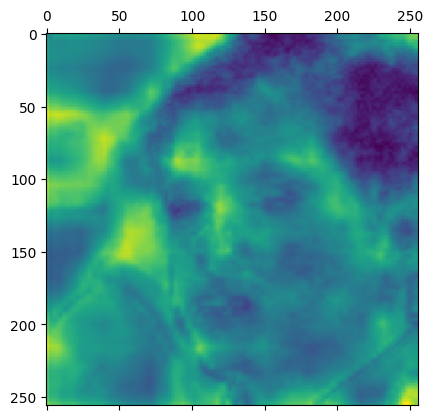

In [ ]:
img_fn_path2 = test_df_FN.iloc[1]["image_path"]
fused_heatmap_fn2 = get_fused_heatmap(img_fn_path2, model)
plt.matshow(fused_heatmap_fn2)
save_and_display_gradcam(img_fn_path2, fused_heatmap_fn2)

<ipython-input-15-10cb15bf560a>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


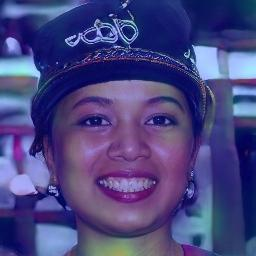

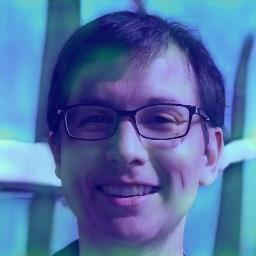

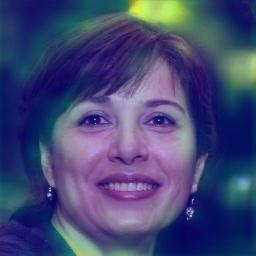

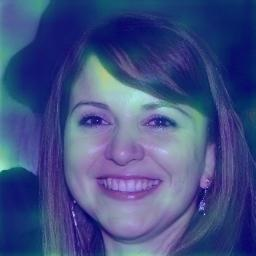

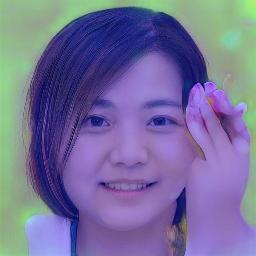

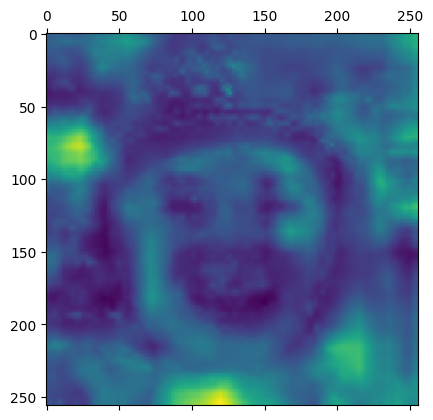

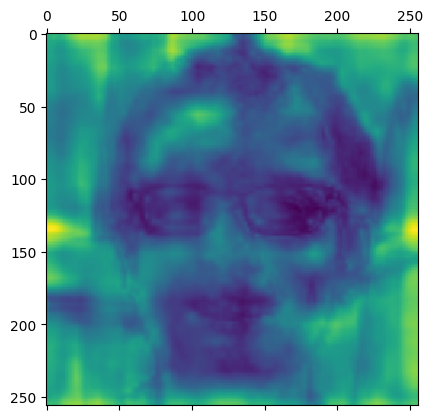

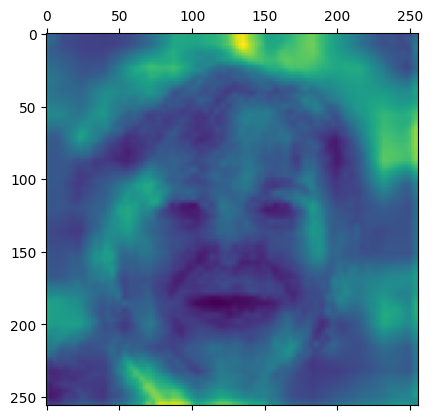

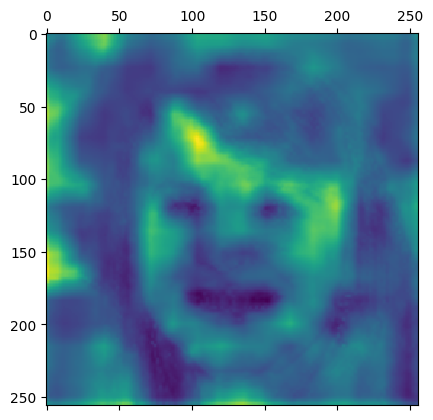

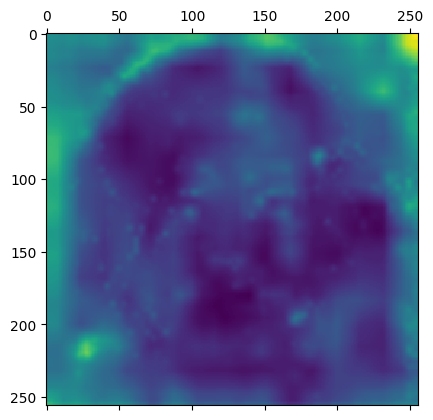

In [ ]:
## FP example
for i in range(len(test_df_FP)):
  img_fp_path1 = test_df_FP.iloc[i]["image_path"]
  fused_heatmap_fp1 = get_fused_heatmap(img_fp_path1, model)
  plt.matshow(fused_heatmap_fp1)
  save_and_display_gradcam(img_fp_path1, fused_heatmap_fp1)